# Soft Actor Critic

#### Off Policy 

## Environment

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

**Continuous Actions:**  Use a `Box(-1, +1, (2,), dtype=np.float32): (np.array([main, lateral]))` action space with two components: 

1. **Main Engine Throttle (`main`):**  
   1. - **Off:**  If `main < 0`.
   2. - **Throttle Scaling:**  Increases linearly from 50% to 100% as `main` ranges from 0 to 1.
   - **Note:**  The main engine does not operate below 50% power.
 
2. **Lateral Boosters Throttle (`lateral`):**
   1. - **Inactive:**  If `-0.5 < lateral < 0.5`.
   2. - **Left Booster:**  Activates when `lateral < -0.5`, scaling throttle from 50% to 100% as `lateral` decreases from -0.5 to -1.
   3. - **Right Booster:**  Activates when `lateral > 0.5`, scaling throttle from 50% to 100% as `lateral` increases from 0.5 to 1.

In [2]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [-0.00357351  1.4071915  -0.3619834  -0.16571614  0.00414768  0.08199443
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


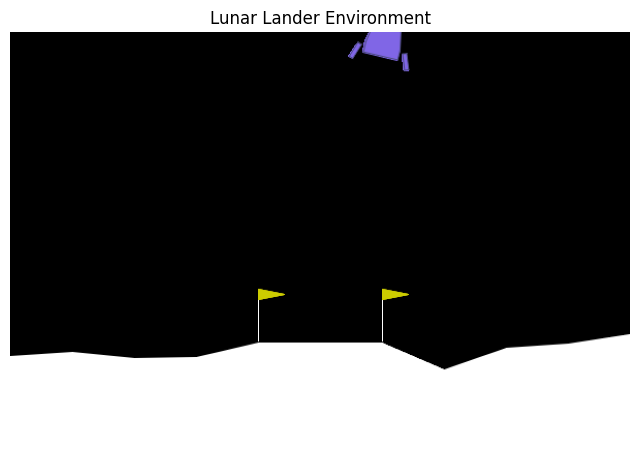

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(40):
    env.step(action=[0, 0])
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Plotting Helper

In [4]:
import matplotlib

In [5]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, policy_losses, value_losses, show_result=False, save_path=None):
    # Create a figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0, 0].set_title("Episode Durations")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Duration")
    axes[0, 0].plot(durations_t.numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0, 0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[0, 1].set_title("Rewards")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Reward")
    axes[0, 1].plot(rewards_t.numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[0, 1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 1].legend()

    # Plot Policy Loss
    policy_t = torch.tensor(policy_losses, dtype=torch.float)
    axes[1, 0].set_title("Policy Loss")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].plot(policy_t.numpy(), label="Policy Loss", color="orange")
    axes[1, 0].legend()

    # Plot Value Loss
    value_t = torch.tensor(value_losses, dtype=torch.float)
    axes[1, 1].set_title("Value Loss")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Loss")
    axes[1, 1].plot(value_t.numpy(), label="Value Loss", color="green")
    axes[1, 1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

## ReplayBuffer

In [6]:
from collections import deque, namedtuple
from typing import Deque, Tuple, List
import numpy as np
from numpy.typing import NDArray

# Define a namedtuple to store experience tuples
Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])


class ReplayBuffer:
    def __init__(self, capacity: int, state_dim: int, action_dim: int):
        """
        Initializes the replay buffer.

        Args:
            capacity (int): Maximum number of experiences to store.
            state_dim (int): Dimensionality of the state.
            action_dim (int): Dimensionality of the action.
        """
        self.capacity: int = capacity
        self.buffer: Deque[Experience] = deque(maxlen=capacity)
        self.state_dim: int = state_dim
        self.action_dim: int = action_dim

    def add(self, state: NDArray, action: NDArray, reward: float, next_state: NDArray, done: bool) -> None:
        """
        Adds an experience to the replay buffer.

        Args:
            state (NDArray): The current state.
            action (NDArray): The action taken.
            reward (float): The reward received.
            next_state (NDArray): The next state.
            done (bool): Whether the episode ended after this step.
        """
        assert state.shape == (self.state_dim,), f"State shape must be ({self.state_dim},)"
        assert action.shape == (self.action_dim,), f"Action shape must be ({self.action_dim},)"
        assert next_state.shape == (self.state_dim,), f"Next state shape must be ({self.state_dim},)"

        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple[NDArray, NDArray, NDArray, NDArray, NDArray]:
        """
        Samples a batch of experiences from the replay buffer.

        Args:
            batch_size (int): Number of experiences to sample.

        Returns:
            Tuple[NDArray, NDArray, NDArray, NDArray, NDArray]: A batch of experiences.
        """
        assert len(self.buffer) >= batch_size, "Not enough samples in the buffer to sample the batch."

        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        experiences: List[Experience] = [self.buffer[idx] for idx in indices]

        # Stack and return the batch
        states = np.array([exp.state for exp in experiences], dtype=np.float32)
        actions = np.array([exp.action for exp in experiences], dtype=np.float32)
        rewards = np.array([exp.reward for exp in experiences], dtype=np.float32)
        next_states = np.array([exp.next_state for exp in experiences], dtype=np.float32)
        dones = np.array([exp.done for exp in experiences], dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self) -> int:
        """
        Returns the current size of the replay buffer.

        Returns:
            int: Number of experiences stored.
        """
        return len(self.buffer)

## Neural Networks

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

In [8]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int):
        """
        Actor Network for policy prediction.

        Args:
            state_dim (int): Dimension of the input state.
            action_dim (int): Dimension of the action space.
            hidden_dim (int): Number of units in hidden layers.
        """
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the actor network.

        Args:
            state (torch.Tensor): Input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and log standard deviation of the actions.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = torch.clamp(self.log_std(x), min=-20, max=2)  # Limit log_std for numerical stability
        return mean, log_std

    def sample_action(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Samples an action using the reparameterization trick.

        Args:
            state (torch.Tensor): Input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Sampled action and log probability of the action.
        """
        mean, log_std = self.forward(state)
        std = torch.exp(log_std)
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # Reparameterization trick
        action = torch.tanh(x_t)  # Enforce action bounds
        log_prob = normal.log_prob(x_t).sum(dim=-1, keepdim=True)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)  # Stability adjustment
        return action, log_prob

In [9]:
class CriticNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int):
        """
        Critic Network to predict Q-values.

        Args:
            state_dim (int): Dimension of the input state.
            action_dim (int): Dimension of the action space.
            hidden_dim (int): Number of units in hidden layers.
        """
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q_value = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the critic network.

        Args:
            state (torch.Tensor): Input state.
            action (torch.Tensor): Input action.

        Returns:
            torch.Tensor: Predicted Q-value.
        """
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.q_value(x)

In [10]:
# Value Network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int):
        """
        Value Network to predict the soft value function.

        Args:
            state_dim (int): Dimension of the input state.
            hidden_dim (int): Number of units in hidden layers.
        """
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the value network.

        Args:
            state (torch.Tensor): Input state.

        Returns:
            torch.Tensor: Predicted value.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.value(x)

In [11]:
# Target Networks
def create_target_network(source_network: nn.Module) -> nn.Module:
    """
    Creates a target network by copying the parameters from a source network.

    Args:
        source_network (nn.Module): Source network to copy parameters from.

    Returns:
        nn.Module: Target network.
    """
    target_network = type(source_network)(*source_network.args)
    target_network.load_state_dict(source_network.state_dict())
    for param in target_network.parameters():
        param.requires_grad = False
    return target_network

## Losses

In [12]:
import torch.optim as optim


class SACLosses:
    def __init__(self, alpha: float = 0.2, automatic_entropy: bool = True, target_entropy: float = -1.0):
        """
        Initializes the loss computation and entropy coefficient handling.

        Args:
            alpha (float): Initial entropy coefficient.
            automatic_entropy (bool): Whether to use automatic entropy adjustment.
            target_entropy (float): Target entropy value.
        """
        self.automatic_entropy = automatic_entropy
        if automatic_entropy:
            self.log_alpha = torch.tensor(
                [torch.log(torch.tensor(alpha))], requires_grad=True, device="cuda" if torch.cuda.is_available() else "cpu"
            )
            self.target_entropy = target_entropy
        else:
            self.alpha = alpha

    def get_alpha(self) -> torch.Tensor:
        """
        Returns the current entropy coefficient.

        Returns:
            torch.Tensor: Entropy coefficient.
        """
        return self.log_alpha.exp() if self.automatic_entropy else torch.tensor(self.alpha)

    def alpha_loss(self, log_prob: torch.Tensor) -> torch.Tensor:
        """
        Computes the loss for the entropy coefficient.

        Args:
            log_prob (torch.Tensor): Log probabilities of actions.

        Returns:
            torch.Tensor: Loss for adjusting the entropy coefficient.
        """
        if self.automatic_entropy:
            return -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()
        return torch.tensor(0.0, device=log_prob.device)


def compute_actor_loss(actor: ActorNetwork, critic_1: CriticNetwork, critic_2: CriticNetwork, states: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
    """
    Computes the actor loss using the reparameterization trick.

    Args:
        actor (ActorNetwork): The actor network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        states (torch.Tensor): Batch of states.
        alpha (torch.Tensor): Entropy coefficient.

    Returns:
        torch.Tensor: Actor loss.
    """
    actions, log_probs = actor.sample_action(states)
    q1 = critic_1(states, actions)
    q2 = critic_2(states, actions)
    q_min = torch.min(q1, q2)
    return (alpha * log_probs - q_min).mean()


def compute_critic_loss(
    critic: CriticNetwork, target_value_net: ValueNetwork, states: torch.Tensor, actions: torch.Tensor, rewards: torch.Tensor,
    next_states: torch.Tensor, dones: torch.Tensor, gamma: float
) -> torch.Tensor:
    """
    Computes the critic loss using the TD error.

    Args:
        critic (CriticNetwork): The critic network.
        target_value_net (ValueNetwork): The target value network.
        states (torch.Tensor): Batch of states.
        actions (torch.Tensor): Batch of actions.
        rewards (torch.Tensor): Batch of rewards.
        next_states (torch.Tensor): Batch of next states.
        dones (torch.Tensor): Batch of done flags.
        gamma (float): Discount factor.

    Returns:
        torch.Tensor: Critic loss.
    """
    with torch.no_grad():
        target_value = target_value_net(next_states)
        target_q = rewards + gamma * (1 - dones) * target_value
    predicted_q = critic(states, actions)
    return nn.MSELoss()(predicted_q, target_q)


def compute_value_loss(
    value_net: ValueNetwork, critic_1: CriticNetwork, critic_2: CriticNetwork, states: torch.Tensor, alpha: torch.Tensor
) -> torch.Tensor:
    """
    Computes the value loss using the Bellman equation.

    Args:
        value_net (ValueNetwork): The value network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        states (torch.Tensor): Batch of states.
        alpha (torch.Tensor): Entropy coefficient.

    Returns:
        torch.Tensor: Value loss.
    """
    with torch.no_grad():
        actions, log_probs = actor.sample_action(states)
        q1 = critic_1(states, actions)
        q2 = critic_2(states, actions)
        q_min = torch.min(q1, q2)
        target_value = q_min - alpha * log_probs
    predicted_value = value_net(states)
    return nn.MSELoss()(predicted_value, target_value)


## Optimization and Target Network Update

In [13]:
def setup_optimizers(
    actor: ActorNetwork, critic_1: CriticNetwork, critic_2: CriticNetwork, value_net: ValueNetwork, learning_rate: float = 3e-4
) -> Tuple[optim.Optimizer, optim.Optimizer, optim.Optimizer, optim.Optimizer]:
    """
    Sets up optimizers for the actor, critic, and value networks.

    Args:
        actor (ActorNetwork): The actor network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        value_net (ValueNetwork): The value network.
        learning_rate (float): Learning rate for the optimizers.

    Returns:
        Tuple[optim.Optimizer, optim.Optimizer, optim.Optimizer, optim.Optimizer]: Optimizers for actor, critics, and value networks.
    """
    actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    critic_1_optimizer = optim.Adam(critic_1.parameters(), lr=learning_rate)
    critic_2_optimizer = optim.Adam(critic_2.parameters(), lr=learning_rate)
    value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)
    return actor_optimizer, critic_1_optimizer, critic_2_optimizer, value_optimizer


def update_target_network(target_value_net: ValueNetwork, value_net: ValueNetwork, tau: float = 0.005) -> None:
    """
    Updates the target value network using Polyak averaging.

    Args:
        target_value_net (ValueNetwork): The target value network.
        value_net (ValueNetwork): The current value network.
        tau (float): Update rate for target networks.
    """
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

## Saving and Loading Models

In [14]:
import os

def save_models(
    directory: str,
    actor: ActorNetwork,
    critic_1: CriticNetwork,
    critic_2: CriticNetwork,
    value_net: ValueNetwork,
    target_value_net: ValueNetwork,
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
    episode: int,
) -> None:
    """
    Saves SAC models and optimizers.

    Args:
        directory (str): Directory to save models.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        optimizers: PyTorch optimizers for each network.
        episode (int): Current training episode for checkpoint naming.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save({
        'actor_state_dict': actor.state_dict(),
        'critic_1_state_dict': critic_1.state_dict(),
        'critic_2_state_dict': critic_2.state_dict(),
        'value_net_state_dict': value_net.state_dict(),
        'target_value_net_state_dict': target_value_net.state_dict(),
        'actor_optimizer_state_dict': actor_optimizer.state_dict(),
        'critic_1_optimizer_state_dict': critic_1_optimizer.state_dict(),
        'critic_2_optimizer_state_dict': critic_2_optimizer.state_dict(),
        'value_optimizer_state_dict': value_optimizer.state_dict(),
        'episode': episode
    }, os.path.join(directory, f'sac_checkpoint_best.pt'))
    print(f"Models saved to {directory}/sac_checkpoint_best.pt")


def load_models(
    checkpoint_path: str,
    actor: ActorNetwork,
    critic_1: CriticNetwork,
    critic_2: CriticNetwork,
    value_net: ValueNetwork,
    target_value_net: ValueNetwork,
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
) -> int:
    """
    Loads SAC models and optimizers from a checkpoint.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        optimizers: PyTorch optimizers for each network.

    Returns:
        int: The episode number from the checkpoint.
    """
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path)

    actor.load_state_dict(checkpoint['actor_state_dict'])
    critic_1.load_state_dict(checkpoint['critic_1_state_dict'])
    critic_2.load_state_dict(checkpoint['critic_2_state_dict'])
    value_net.load_state_dict(checkpoint['value_net_state_dict'])
    target_value_net.load_state_dict(checkpoint['target_value_net_state_dict'])

    actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
    critic_1_optimizer.load_state_dict(checkpoint['critic_1_optimizer_state_dict'])
    critic_2_optimizer.load_state_dict(checkpoint['critic_2_optimizer_state_dict'])
    value_optimizer.load_state_dict(checkpoint['value_optimizer_state_dict'])

    episode = checkpoint['episode']
    print(f"Models loaded from {checkpoint_path}, resuming at episode {episode}")
    return episode


## Training

In [15]:
from tqdm import tqdm
from datetime import datetime


def train_sac(
    env: gym.Env,
    actor: ActorNetwork,
    critic_1: CriticNetwork,
    critic_2: CriticNetwork,
    value_net: ValueNetwork,
    target_value_net: ValueNetwork,
    replay_buffer: ReplayBuffer,
    sac_losses: SACLosses,
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
    num_episodes: int = 1000,
    batch_size: int = 64,
    gamma: float = 0.99,
    tau: float = 0.005,
    evaluate_interval: int = 10,
) -> None:
    """
    Trains the SAC agent.

    Args:
        env (gym.Env): The environment.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        replay_buffer (ReplayBuffer): Experience replay buffer.
        sac_losses (SACLosses): Loss computation module.
        optimizers: PyTorch optimizers for each network.
        num_episodes (int): Number of training episodes.
        batch_size (int): Batch size for training.
        gamma (float): Discount factor.
        tau (float): Target network update rate.
        evaluate_interval (int): Interval for evaluation and visualization.
    """
    global episode_durations, episode_rewards, policy_losses, value_losses, steps_taken

    # Create output directory with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"output/training_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    best_reward = float('-inf')

    progress_bar = tqdm(total=num_episodes, desc="Training Progress", position=0, leave=True)

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0
        duration = 0

        while True:
            # Select action using the policy
            with torch.no_grad():
                action, _ = actor.sample_action(state.unsqueeze(0))
                action = action.squeeze(0).numpy()

            # Interact with the environment
            next_state, reward, truncated, terminated, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            total_reward += reward
            duration += 1
            steps_taken += 1

            if truncated or terminated:
                done = True
            else:
                done = False

            if duration >= 999:
                done = True

            # Add experience to the replay buffer
            replay_buffer.add(state.numpy(), action, reward, next_state.numpy(), done)

            state = next_state

            # Update networks if the buffer is large enough
            if len(replay_buffer) >= batch_size:
                # Sample minibatch
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.float32)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                # Compute losses
                alpha = sac_losses.get_alpha()
                actor_loss = compute_actor_loss(actor, critic_1, critic_2, states, alpha)
                critic_1_loss = compute_critic_loss(critic_1, target_value_net, states, actions, rewards, next_states, dones, gamma)
                critic_2_loss = compute_critic_loss(critic_2, target_value_net, states, actions, rewards, next_states, dones, gamma)
                value_loss = compute_value_loss(value_net, critic_1, critic_2, states, alpha)
                entropy_loss = sac_losses.alpha_loss(actor.sample_action(states)[1])

                # Optimize actor
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Optimize critics
                critic_1_optimizer.zero_grad()
                critic_1_loss.backward()
                critic_1_optimizer.step()

                critic_2_optimizer.zero_grad()
                critic_2_loss.backward()
                critic_2_optimizer.step()

                # Optimize value
                value_optimizer.zero_grad()
                value_loss.backward()
                value_optimizer.step()

                # Optimize alpha if using automatic entropy
                if sac_losses.automatic_entropy:
                    entropy_loss.backward()
                    sac_losses.log_alpha.grad -= entropy_loss.detach()

                # Update target network
                update_target_network(target_value_net, value_net, tau)

                # Track losses
                policy_losses.append(actor_loss.item())
                value_losses.append(value_loss.item())

                # Update progress bar with current metrics
                progress_bar.set_postfix({
                    "Episode": episode + 1,
                    "Steps Taken": steps_taken,
                    "Total Reward": total_reward,
                    "Episode Duration": duration,
                    "Avg Policy Loss": np.mean(policy_losses[-10:]) if len(policy_losses) > 10 else 0,
                    "Avg Value Loss": np.mean(value_losses[-10:]) if len(value_losses) > 10 else 0
                })
            if done:
                break

        # Track episode metrics
        episode_rewards.append(total_reward)
        episode_durations.append(duration)

        progress_bar.update(1)

        # Save the best model
        if total_reward > best_reward:
            best_reward = total_reward
            save_models(
                output_dir,
                actor,
                critic_1,
                critic_2,
                value_net,
                target_value_net,
                actor_optimizer,
                critic_1_optimizer,
                critic_2_optimizer,
                value_optimizer,
                episode
            )
            print(f"New best model saved with reward: {best_reward:.2f}")
        
        plot_metrics(episode_durations, episode_rewards, episode_durations, episode_rewards)

        # Evaluate periodically
        # if episode % evaluate_interval == 0:
        #     evaluate_sac(env, actor)
    
    progress_bar.close()

    print("Training complete.")

In [16]:
def evaluate_sac(env: gym.Env, actor: ActorNetwork, num_episodes: int = 5) -> None:
    """
    Evaluates the SAC agent.

    Args:
        env (gym.Env): The environment.
        actor (ActorNetwork): Trained actor network.
        num_episodes (int): Number of evaluation episodes.
    """
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0

        while True:
            with torch.no_grad():
                action, _ = actor.sample_action(state.unsqueeze(0))
                action = action.squeeze(0).numpy()

            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32)

            if done:
                break

        print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

## Initializations

In [17]:
state_dim = n_observations
action_dim = 2
hidden_dim = 256

### Replay Buffer

In [18]:
replay_buffer = ReplayBuffer(100000, n_observations, action_dim)

### SAC Losses

In [19]:
sac_losses = SACLosses()

### Initialize Neural Networks

In [20]:
# Initialize networks
actor = ActorNetwork(state_dim, action_dim, hidden_dim)
critic_1 = CriticNetwork(state_dim, action_dim, hidden_dim)
critic_2 = CriticNetwork(state_dim, action_dim, hidden_dim)
value_net = ValueNetwork(state_dim, hidden_dim)

# Create target network
target_value_net = ValueNetwork(state_dim, hidden_dim)
target_value_net.load_state_dict(value_net.state_dict())

<All keys matched successfully>

### Initialize Optimizers

In [21]:
actor_optimizer, critic_1_optimizer, critic_2_optimizer, value_optimizer = setup_optimizers(actor, critic_1, critic_2, value_net, learning_rate = 3e-4)

### Train

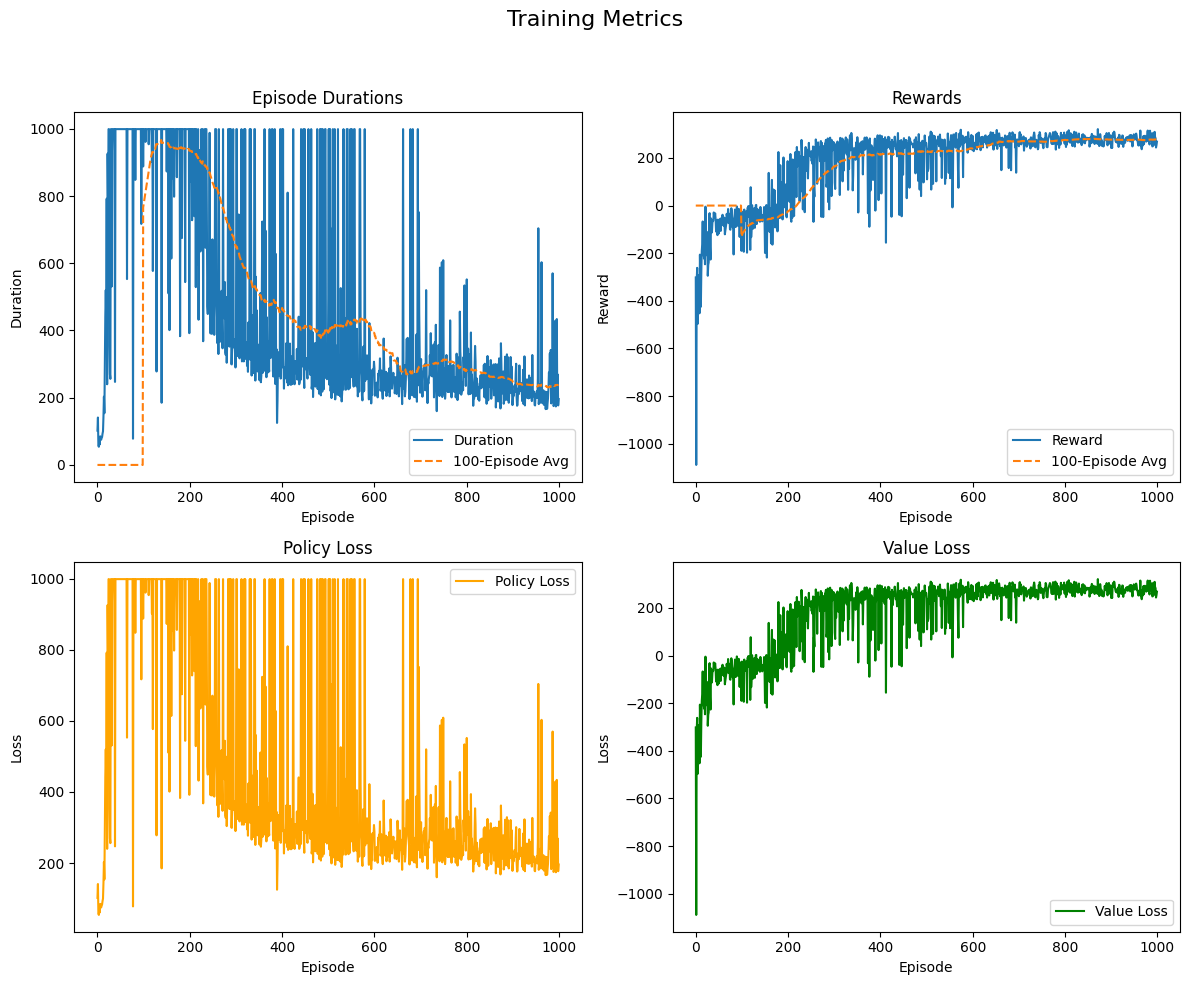

Training Progress: 100%|██████████| 1000/1000 [55:08<00:00,  3.31s/it, Episode=1000, Steps Taken=466714, Total Reward=268, Episode Duration=196, Avg Policy Loss=-77.3, Avg Value Loss=0.229]

Training complete.


In [22]:
# Global metrics to track performance
episode_durations = []
episode_rewards = []
policy_losses = []
value_losses = []
steps_taken = 0

train_sac(
    env,
    actor,
    critic_1,
    critic_2,
    value_net,
    target_value_net,
    replay_buffer,
    sac_losses,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    value_optimizer,
    num_episodes = 1000,
    batch_size = 64,
    gamma = 0.99,
    tau = 0.005,
    evaluate_interval = 10,
)

Metrics figure saved to output/training_20241223_111722/details


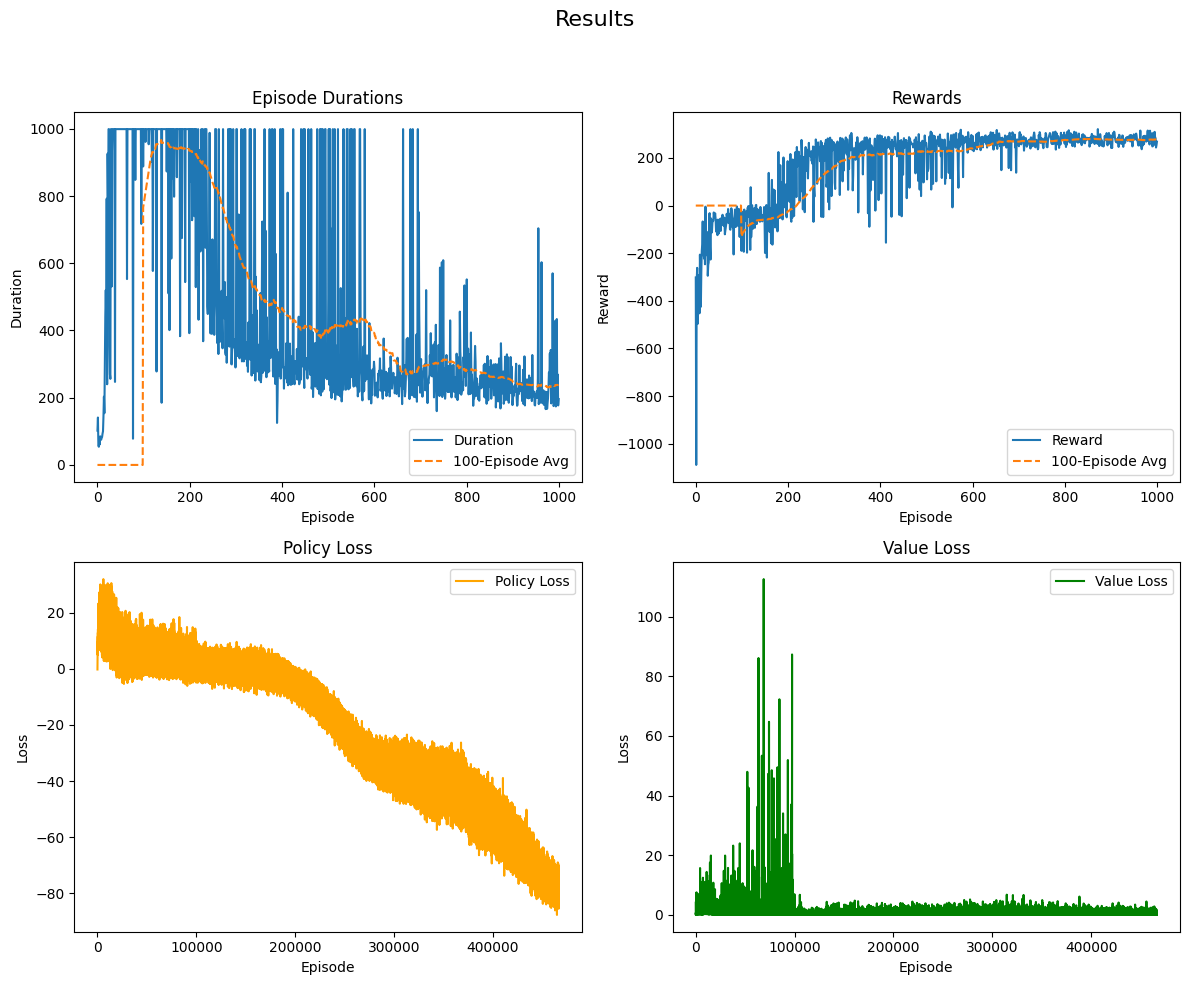

In [27]:
plot_metrics(
    episode_durations,
    episode_rewards,
    policy_losses,
    value_losses,
    show_result=True,
    save_path="output/training_20241223_111722/details",
)